# Analítica y Ciencia de Datos

## CIDE - Otoño 2015

### Árboles de Clasificación y Regresión

# Referencias

Capítulo 9 de [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn.1stEd/).

Capítulo 8 de [ISL](http://www-bcf.usc.edu/~gareth/ISL/)

[Capítulo 11 del Handbook of Statistics, Vol 23](http://mason.gmu.edu/~csutton/vt6.pdf)

# Árboles de Decisión


* En las notas anteriores vimos dos formas de estimar modelos no lineales: 

    * **Modelos no lineales de regresión**: hacer una aproximación de primer orden un modelo no lineal (en parámetros), y obtuvimos un método simple de actualización por medio de OLS iterativo.
    * **Modelos Aditivos Generalizados**
    

* Ahora vamos a ver una clase de modelos muy simples y poderosos: *árboles de decisión*.


* La idea es simple: los regresores $X_1, X_2, \cdots, X_p$ generan el espacio $X_1 \times X_2 \times \cdots \times X_p$


* Vamos a dividir este espacio en rectángulos: $R_m$


* La estimación de $y$ en $R_m$ es la media restringida a ese rectángulo.

# Ejemplo: dos regresores contínuos $X_1$, $X_2$

 ![caption](figures/cart_libro.png)
 
 [Figura 9.2 de ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn.1stEd/)

# Aproximación de la función

* En el ejemplo anterior aproximamos la función que queremos aprender como 

$$
f(x) = \sum_{m=1}^5 c_m I\{(X_1, X_2) \in R_m\}
$$


* Podemos capturar no linealidades de los regresores que en pueden ser difíciles de capturar con otros modelos.


* La figura muestra que el *primer corte* se hace con el primer regresor $X_1$ utilizando el punto de corte o *threshold* $t_1$.

> Este corte hace una primera partición del espacio de regresores.


* El algoritmo se llama **CART (Classification and Regression Trees)** y sólo hace cortes binarios

    * En cada iteración busca simultáneamente el regresor que tiene un mayor poder predictivo y el punto de corte correspondiente.
    
    * En este caso la interpretación es simple: el regresor con mayor poder predictivo es $X_1$.
    

* Después explora cada lado del árbol:

* **A la izquierda**: condicionamos a $X_1 \leq t_1$ y buscamos nuevamente el regresor con mayor poder predictivo y el punto de corte correspondiente $(X_2, t_2)$.

* **A la derecha**: condicionamos a $X_1 > t_1$ y buscamos nuevamente el regresor con mayor poder predictivo y el punto de corte correspondiente $(X_1, t_3)$.


* Principal ventaja de los CART: son fáciles de explicar y de interpretar.


# Definiendo un árbol de decisión


* La figura muestra.

 ![caption](figures/binary_tree.png)
 
(Tomado de [acá](http://algs4.cs.princeton.edu/32bst/images/binary-tree-anatomy.png)) 

* Los árboles de decisión se leen de arriba hacia abajo.


* El primer nodo es el *nodo inicial*, *base* o *raíz*.

* Los **nodos finales** indican que no se hacen más cortes.

* Cada nodo genera un subárbol o *subtree* del árbol inicial.



# Árboles de regresión:


* Queremos modelar la función $f(x)$ como 

$$
f(x)  = \sum_{m=1}^M c_m I(x \in R_m)
$$


* Vamos a utilizar como criterio para comparar modelos la suma de residuos al cuadrado, así que vamos a buscar minimizarla.


* Si conociéramos las regiones, sabemos que el estimador de OLS es:

$$
c_m = \overline{y}_{x \in R_m}
$$


*  Cómo funciona el algoritmo:

* En cada iteración vamos a buscar simultáneamente el regresor y punto de corte correspondiente que minimizan el SSR, condicionando en la región en la que estamos buscando.

* **Primera iteración**:

    1. Loop sobre cada regresor $k$:

        * Loop sobre un grid de valores que puede tomar el regresor correspondiente: $t_k \in [\min X_k, \max X_k]$
        
        * Cada $t_k$ genera dos regiones y obtenemos la media de $y$ en esa región:  
$$
X_k \leq t_k \implies c_l\\
X_k > t_k \implies c_r
$$
        * Obtenemos el SSR correspondiente $\sum_i (y_i - c_l)^2 + (y_i - c_r)^2$ y lo guardamos.
        * Buscamos la combinación $(X_k, t_k)$ que minimiza el SSR
        

* Las demás iteraciones hacen lo mismo: pero tenemos que condicionar por la región en la que estamos buscando.

In [6]:
# Veamos un ejemplo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
#sys.path.append('//Users//danielvaughan//Documents//Python Scripts//')
sys.path.append('C:\\Users\\a3940004.EDIFICIOS\\Documents\\Python Scripts\\')
import olsdan as ols

# importemos los datos
#data = pd.read_csv('//Users//danielvaughan//Documents//Clase CIDE//Slides//Analitica//datasets//Credit.csv')
data = pd.read_csv(u'D:\\Míos\\Clase CIDE\\Slides\\Analitica\\New_CIDE_Analytics\\data\\Credit.csv')
N = data.shape[0]
dum_hombre     = np.asarray(data.Gender == ' Male').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
dum_ethnic = np.asarray(pd.get_dummies(data.Ethnicity).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Score','Ingreso',u'Límite de Crédito',u'Número Tarjetas','Edad',u'Educación'])
#,'Hombre','Estudiante','Casado','Caucasian','Asian'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
# transformemos el saldo: es positivo siempre, así que una log() nos da algo más parecido a una normal
yy    = np.log(saldo + 0.000001)

nvar = prexmat.shape[1]

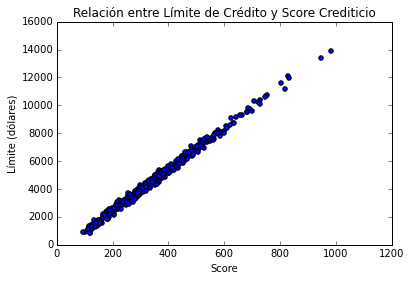

In [11]:
# Por qué están tan parecidas score y límite?  Correlación altísima: casi 1-1!
# así que eliminemos una.  
plt.scatter(data.Rating, data.Limit)
plt.title(u'Relación entre Límite de Crédito y Score Crediticio')
plt.ylabel(u'Límite (dólares)')
plt.xlabel('Score')


prexmat = np.concatenate((
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                         ),axis=1)
labs_x = np.array(['Ingreso',u'Límite de Crédito',u'Número Tarjetas','Edad',u'Educación'])
nvar = prexmat.shape[1]

la primera variable es:  Límite de Crédito
el punto de corte es:  3189.51666667


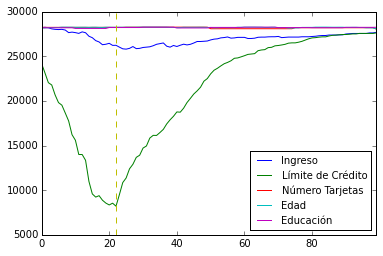

In [368]:
# primera iteracion
# Tamaño del grid
G = 100
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = np.asarray(xk>gridk[t]).reshape((N,1))
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'la primera variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')

#guardemos el threshold, y la variable
Nodes = list([[var_min,thr_min]])

la segunda variable es:  Límite de Crédito
el punto de corte es:  2724.14393939


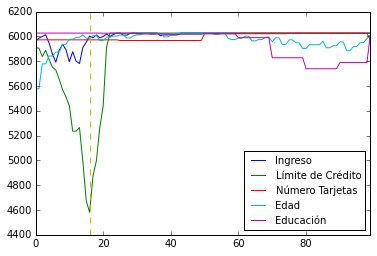

In [369]:
# Segunda Iteración: explorar a la izquierda de este primer nodo
# definamos la región donde queremos explorar:
ind_reg = prexmat[:,Nodes[0][0]] <= Nodes[0][1]
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'la segunda variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((np.ones((N,1)),ind_reg.reshape((N,1))),axis=1)

la tercera variable es:  Límite de Crédito
el punto de corte es:  4663.1969697


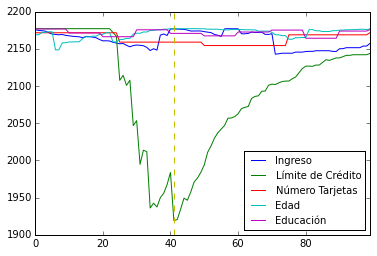

In [370]:
# Repitamos del lado derecho
# Segunda Iteración: explorar a la izquierda de este primer nodo
# definamos la región donde queremos explorar:
ind_reg = prexmat[:,Nodes[0][0]] > Nodes[0][1]
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'la tercera variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

([], <a list of 0 Text yticklabel objects>)

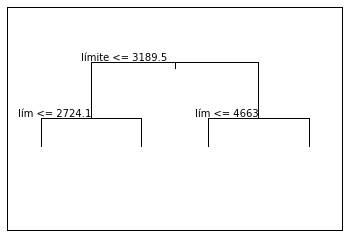

In [371]:
# Resumen hasta el momento
plt.plot([-10,10],[0,0], color='k')
plt.plot([0,0],[-0.1,0], color='k')
plt.text(-1,0,u'límite <= 3189.5', verticalalignment='bottom', horizontalalignment='right')
# siguiente nivel:
plt.plot([-10,-10],[-1,0], color='k')
plt.plot([10,10],[-1,0], color='k')
plt.plot([-16,-4],[-1,-1], color='k')
plt.plot([-16,-16],[-1.5,-1], color='k')
plt.plot([-4,-4],[-1.5,-1], color='k')
plt.plot([4,16],[-1,-1], color='k')
plt.plot([4,4],[-1.5,-1], color='k')
plt.plot([16,16],[-1.5,-1], color='k')
plt.text(-10,-1,u'lím <= 2724.1', verticalalignment='bottom', horizontalalignment='right')
plt.text(10,-1,u'lím <= 4663', verticalalignment='bottom', horizontalalignment='right')
# axis
plt.axis([-20,20,-3,1])
plt.xticks([])
plt.yticks([])

In [372]:
pd.DataFrame(RegMat==1).mean()

0    1.0000
1    0.2675
2    0.7325
dtype: float64

siguiente variable es:  Ingreso
el punto de corte es:  23.4079025253


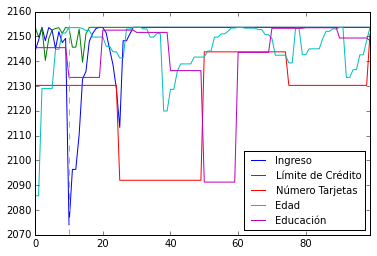

In [373]:
# Cuarta Iteración: explorar a la izquierda del segundo nodo
# Primero: obtengamos el padre de este nodo
padre  = Nodes[1][-1]
abuelo = Nodes[1][-2]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]] <= padre[1],
                      prexmat[:,abuelo[0]] <= abuelo[1])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Ingreso
el punto de corte es:  26.8104282828


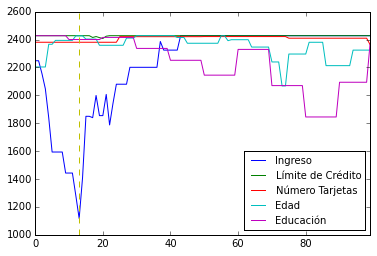

In [374]:
# Quinta Iteración: explorar a la derecha del segundo nodo
# Primero: obtengamos el padre de este nodo
padre  = Nodes[1][-1]
abuelo = Nodes[1][-2]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]] > padre[1],
                      prexmat[:,abuelo[0]] <= abuelo[1])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Ingreso
el punto de corte es:  58.5673353535


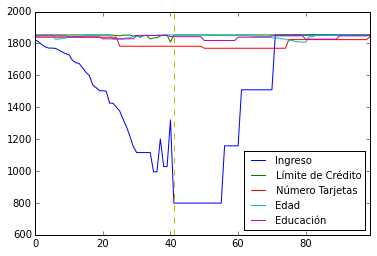

In [375]:
# Sexta Iteración: explorar a la derecha del segundo nodo
# Primero: obtengamos el padre de este nodo
padre  = Nodes[2][-1]
abuelo = Nodes[2][-2]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]] <= padre[1],
                      prexmat[:,abuelo[0]] > abuelo[1])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Límite de Crédito
el punto de corte es:  5361.25606061


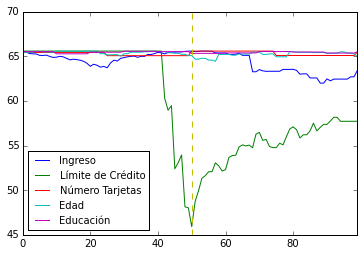

In [376]:
# Séptima Iteración: explorar a la derecha del segundo nodo
# Primero: obtengamos el padre de este nodo
padre  = Nodes[2][-1]
abuelo = Nodes[2][-2]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  > padre[1],
                      prexmat[:,abuelo[0]] > abuelo[1])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

In [377]:
# Confirmemos que hemos venido haciendo bien los cortes
pd.DataFrame(RegMat==1).mean()

0    1.0000
1    0.2675
2    0.7325
3    0.1975
4    0.0700
5    0.2375
6    0.4950
dtype: float64

In [378]:
Nodes

[[1, 3189.5166666666655],
 [[1, 3189.5166666666655], [1, 2724.1439393939386]],
 [[1, 3189.5166666666655], [1, 4663.1969696969682]],
 [[1, 3189.5166666666655], [0, 23.407902525252521]],
 [[1, 3189.5166666666655], [0, 26.810428282828276]],
 [[1, 3189.5166666666655], [0, 58.567335353535334]],
 [[1, 3189.5166666666655], [1, 5361.2560606060579]]]

siguiente variable es:  Ingreso
el punto de corte es:  22.2737272727


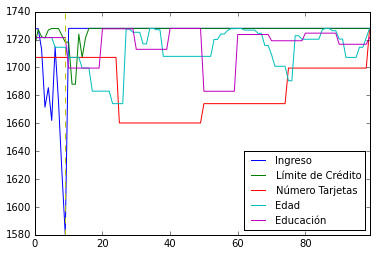

In [379]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[3][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  <= padre[1],
                      RegMat[:,3])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Edad
el punto de corte es:  29.0


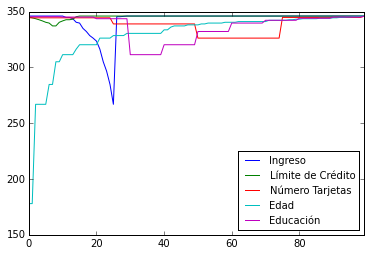

In [380]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[3][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  > padre[1],
                      RegMat[:,3])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Ingreso
el punto de corte es:  15.4686757576


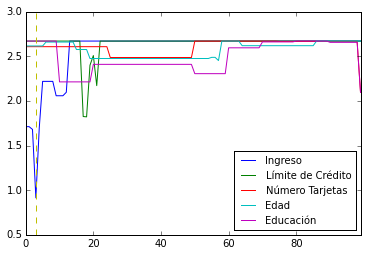

In [381]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[4][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  <= padre[1],
                      RegMat[:,4])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Educación
el punto de corte es:  16.2828282828


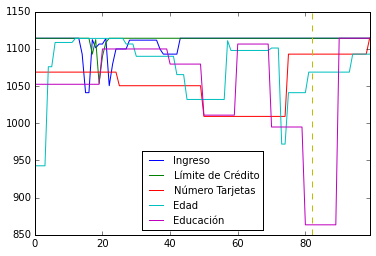

In [382]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[4][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  > padre[1],
                      RegMat[:,4])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

siguiente variable es:  Ingreso
el punto de corte es:  52.8964590909


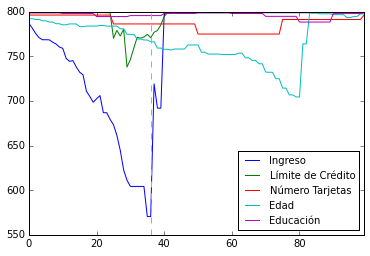

In [383]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[5][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  <= padre[1],
                      RegMat[:,5])
# podemos hacer un copy-paste del código anterior (sólo tenemos que tener cuidado con el ind_reg)
#--------------------------------------
# Queremos guardar los resultados acá
SSRMat = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # el grid va a ser sobre los percentiles 5% y 95%
    q05   = np.percentile(xk,5)
    q95   = np.percentile(xk,95)
    gridk = np.linspace(q05,q95,G)
    # empezamos el loop sobre el grid
    for t in range(G):
        dum_kt = 1.0*(np.asarray(xk>gridk[t]).reshape((N,1)))
        # para condicionar que la búsqueda sea sobre ind_reg vamos a utilizar NaNs
        # LA FUNCION OLS_DAN ELIMINA LAS FILAS DONDE HAY NANS
        dum_kt[ind_reg==False] = np.nan
        xmat   = np.concatenate((np.ones((N,1)), dum_kt),axis=1)
        olstk  = ols.ols_dan(yy, xmat)
        # guardemos el ssr
        SSRMat[t,k] = olstk.ssr()

# guardemos el menor, y el threshold correspondiente
ssr_min = SSRMat.min()        
var_min = np.dot(((SSRMat==ssr_min).mean(axis=0)>0),np.arange(nvar))
# ahora el threshold
xk    = prexmat[:,var_min].copy()
q05   = np.percentile(xk,5)
q95   = np.percentile(xk,95)
gridk = np.linspace(q05,q95,G)
ixmin = np.argmin(SSRMat[:,var_min])
thr_min = gridk[ixmin]
print 'siguiente variable es: ', labs_x[var_min]
print 'el punto de corte es: ', thr_min

# grafiquémoslo
SSRMat = pd.DataFrame(SSRMat, columns = labs_x)
SSRMat.plot()        
plt.legend(loc='best', fontsize=10)
ymin, ymax = plt.ylim()
plt.plot([ixmin, ixmin],[ymin,ymax], ls='--')
#Actualicemos la lista donde guardamos el árbol
Nodes.append([Nodes[0],[var_min,thr_min]])
# Es útil guardar la región correspondiente al nodo que acabamos de explorar:
# Las columnas corresponderán al orden de los nodos
RegMat = np.concatenate((RegMat,ind_reg.reshape((N,1))),axis=1)

In [384]:
# Siguiente iteración
# Primero: obtengamos el padre de este nodo
padre  = Nodes[5][-1]
# definamos la región donde queremos explorar:
ind_reg = np.multiply(prexmat[:,padre[0]]  > padre[1],
                      RegMat[:,5])
# miremos que tenemos el mínimo de observaciones necesario
print ind_reg.sum()


3.0


# Resumen del algoritmo:

* Ya vimos que el proceso es simple pero tiene una única complicación:

> **Es fundamental saber en qué región estamos explorando (RegMat) y en qué nodo estamos**


* La región, nodos y sus antescesores fueron actualizados iterativamente, explorando el árbol de arriba a abajo (naturalmente) y de izquierda a derecha (esto no es necesario, se puede hacer una exploración por ramas).


* Un algoritmo haría esto con un loop.

# ¿Cómo funciona el algoritmo con variables categóricas?


* Las iteraciones anteriores se hicieron con variables continuas.


* Para cada variable $k$, se evaluaron diferentes puntos de corte $t_{kj}$, y se calcularon variables dummies $X_k \leq t_{kj}$.


* Pero esto no se puede hacer con variables categóricas.


* Tomemos el caso de una variable dummy $D_i \in \{0,1\}$.


* En este caso el grid tiene sólo dos valores, así que es inmediato calcular el $SSR$:

$$
\sum_i (y_i - c_{D=0})^2 + (y_i - c_{D=1})^2
$$


* O en nuestro algoritmo, corremos la regresión 
$$
y_i = \alpha + \beta D_i + \epsilon_i
$$

y guardamos el $SSR$ correspondiente.


* En el caso de más de dos categorías incluimos todas las variables dummy correspondientes *excluyendo* la categoría de referencia.

# CART con Scikit-learn


* Ya vimos cómo funciona el algoritmo.


* Una ventaja que tiene usar Scikit-learn es que nos permite estimar un CART fácilmente, pero sobre todo **visualizarlo**.


* El proceso no es inmediato: se necesita tener instalado [Graphviz](http://www.graphviz.org/).


* Yo instalé [esta versión (Mac OS)](http://www.ryandesign.com/graphviz/) y tuve que actualizar mi [XQuartz](http://xquartz.macosforge.org/).


* También instalé la versión de Windows.


* Una vez instalado tienen que incluir la carpeta en el `PATH`.

In [14]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(prexmat, yy)
labs_x = np.array(['Ingreso',u'CredLim',u'NumTarjetas','Edad',u'Edu'])


tree.export_graphviz(clf,out_file='tree.dot', feature_names=labs_x) 

# Graphviz

* Una vez tenemos el archivo `tree.dot` necesitamos la función `dot` de Graphviz para convertirlo a `.png`:


* Ver [la documentación oficial](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html).


* Dada mi instalación de Graphviz (y que no cambié el path), tuve que hacer lo siguiente:


>  `/usr/local/graphviz-2.14/bin/dot -Tpng tree.dot -o tree.png`




 ![caption](figures/tree4.png)

# Modelos de *Clasificación*

* Como su nombre lo indica, los CART sirven también para clasificar.


* Supongamos que tenemos $K \geq 2$ categorías.


* Al igual que en el caso de regresión, cada nodo $m$ representa una región $R_m$ con $n_m$ observaciones.


* Definamos la probabilidad de asignar correctamente a categoría $k$ en el nodo $m$: 

$$
\hat{p}_{mk} = \frac{1}{n_m} \sum_{x_i \in R_m} I(y_{i}=k) 
$$


* En el nodo $m$ clasificamos una observación en la categoría 

$$
k(m) = \arg \max_{k} \hat{p}_{km}
$$

# Métricas de ajuste o pureza


* En regresión utilizamos el $SSR$ para seleccionar la región y el regresor correspondiente.


* En clasificación hay tres candidatos (pero sólo se utilizan los últimos dos):


**Error de Clasificación:**

$$
\frac{1}{n_m} \sum_{x_i \in R_m} I (y_i \neq k(m)) = 1- \hat{p}_{mk(m)}
$$


**Índice de Gini** (no confundir con el coeficiente de Gini!):

$$
\sum_k \hat{p}_{mk}(1-\hat{p}_{mk}) = 1 - \sum_k \hat{p}_{mk}^2
$$


**Entropía cruzada o *deviance*:**

$$
- \sum_k \hat{p}_{mk} \log(\hat{p}_{mk})
$$


* Intuitivamente un nodo es *puro* cuando las observaciones se clasifican en una sola categoría.




# En el caso de 2 categorías

![caption](figures/purity.png)

[Figura 9.3 de ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn.1stEd/)

# Interpretación


* El *Índice de Gini* es muy bajo cuando todos los $\hat{p}_{mk}$ están cerca a cero o a uno.

> **Por esto se considera que es una medida de la *pureza* del nodo.  
Un valor bajo significa que se clasifican las observaciones predominantemente en una categoría.**

> Se puede interpretar como la varianza en la clasificación: deseamos alta pureza y baja varianza.

* La *entropía cruzada* siempre es positiva:  

$$
\hat{p}_{mk} \in [0,1] \implies \log(\hat{p}_{mk}) <0
$$


> También es muy bajo cuando todos los $\hat{p}_{mk}$ están cerca a cero o uno.

# Cómo se calcula la "impureza" de un nodo


* Tomemos como ejemplo el primer nodo (raíz o inicial).


* En ese nodo no hay restricciones sobre el espacio de regresores, así que tomamos la probabilidad incondicional:


* **Veamos el caso del Gini (la entropía es análogo)**:

$$
\begin{eqnarray*}
Gini_{root} &=& 1 - \hat{Prob}(y=1)^2 - \hat{Prob}(y=0)^2 \\
&=& 1 - \left( \frac{\# \{y_i = 1 \}}{N}\right)^2 - \left( \frac{\# \{y_i = 0\}}{N}\right)^2
\end{eqnarray*}
$$


* Si sólo tenemos observaciones con $y=1$ o $y=2$, tenemos un nodo raíz totalmente puro y el Gini es uno.

# Cómo seleccionamos el primer corte: variable continua



* Supongamos que tenemos una candidata $X_1$ que es una variable continua que toma valores en el rango $[\underline{x}, \bar{x} ]$


* Tomemos un punto de corte candidato $\psi \in [\underline{x}, \bar{x} ]$


* Este punto de corte genera dos regiones 
$$
R_l = X_1 \times \cdots \times X_p |_{X_1 \leq \psi} \\
R_r = X_1 \times \cdots \times X_p |_{X_1 > \psi}
$$

* Así que tenemos dos Ginis, uno para $R_l$ y otro para $R_r$:

$$
G_l = 1 - \hat{Prob}(y=1|R_l)^2 - \hat{Prob}(y=0|R_l)^2 \\
G_r = 1 - \hat{Prob}(y=1|R_r)^2 - \hat{Prob}(y=0|R_r)^2 \\
$$


* El Gini asociado no es más que el *valor esperado* (condicional al nodo padre, que en este caso es la raíz)

$$
E(G) = prob(R_l)G_l + prob(R_r)G_r
$$

donde $prob(R_l)$ es la fracción de observaciones que están en $R_l$, es decir 
$$
\frac{\#\{i: x_{1i} \leq \psi \}}{N}
$$


* El *loop* busca todos los posibles $\phi_k$, y obtiene, para cada variable, el corte que minimiza el índice de Gini.


* Al final seleccionamos la variable que tenga el menor Gini, y su punto de corte correspondiente.

# Qué pasa en los siguientes cortes?



* El proceso continua, pero hay que tener en cuenta que las probabilidades son condicionales a estar en la región actual.


* En cada corte hay dos pasos:

    * **Cálculo del Gini de cada rama**: hay que condicionar por $R_p \cap R_{rama}$, donde $R_p$ es la región del nodo padre.

    * **Cálculo de las probabilides condicionales**: 


así, en la rama izquierda del nodo $p$
$$
prob(R_l|R_p) = \frac{\#\{i: x_{1i} \leq \psi \wedge i \in R_p\}}{N_p}
$$


In [114]:
# veamos un ejemplo
#data  = pd.read_excel('//Users//danielvaughan//Documents//Clase CIDE//Slides//Analitica//datasets//data_tarea6.xlsx')
data  = pd.read_excel('E:\\Slides\\Analitica\\datasets\\data_tarea6.xlsx')

N  = data.shape[0]
nobs = N
yy    = 1*np.asarray(data.UN_MESES_SINPAGO>0).reshape((nobs,1))
male  = 1*np.asarray(data.SEXO=='M').reshape((nobs,1))
edad  = np.asarray(data.EDAD_CLIENTE).reshape((nobs,1))
payr  = np.asarray(data.PAYRATIO_PROM_6M_ANTES).reshape((nobs,1))
saldo = np.asarray(data.BALANCE_PROM_6M_ANTES).reshape((nobs,1))
uso   = np.asarray(data.USOVECES_PROM_6M_ANTES).reshape((nobs,1))
score = np.asarray(data.SCORE_LAST).reshape((nobs,1)).astype('float')
score[score<0] = np.nan
# regresores continuos
prexmat = np.concatenate((edad, payr, saldo, uso, score,male),axis=1)
labs_x  = np.array(['Edad','PayR','Saldo','Uso','Score','Hombre'])
nvar = prexmat.shape[1]

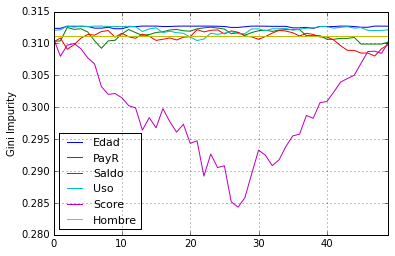

In [153]:
G = 50
ImpMat  = np.zeros((G,nvar))
for k in range(nvar):
    # seleccionemos la variable
    xk    = prexmat[:,k].copy()
    # miremos si es continua (ordinal) o categórica (en este caso sólo dos categorías)
    cont_chk = pd.Series(xk).unique().shape[0]>2
    if cont_chk==True:
        # el grid va a ser sobre los percentiles 5% y 95%
        q05   = np.percentile(pd.Series(xk).dropna(),5)
        q95   = np.percentile(pd.Series(xk).dropna(),95)
        gridk = np.linspace(q05,q95,G)
        # empezamos el loop sobre el grid
        for t in range(G):
            # Definamos la región actual
            dum_kt = (np.asarray(xk<=gridk[t])).flatten()
            # NaNs de la región deben corresponder a las variables
            dum_kt[np.isnan(xk)] = np.nan
            #---------------------------------------
            # Ahora miremos las medidas de impurity:
            #---------------------------------------
            # Primero: las probabilidades de caer a la izquierda o derecha 
            frac_l = (dum_kt==True).mean()
            frac_r = (dum_kt==False).mean()
            # Segundo: Probabilidad condicional de estar en la categoría 1 (en el corte actual)
            p_mk_l = np.nanmean(yy[dum_kt==True])
            p_mk_r = np.nanmean(yy[dum_kt==False])
            # 1. Gini en cada lado del nodo
            gini_l = 1 - p_mk_l**2 - (1-p_mk_l)**2
            gini_r = 1 - p_mk_r**2 - (1-p_mk_r)**2
            sum_gini    = frac_l*gini_l + frac_r*gini_r
            ImpMat[t,k] = sum_gini
    else:
        # Para las variables categóricas: cada región es una categoría
        # En este caso (hombre=1) se que los valores son 1 y cero
        dum_kt = (xk==True)
        dum_kt[np.isnan(xk)] = np.nan
        # Primero: las probabilidades de caer a la izquierda o derecha 
        frac_l = (dum_kt==True).mean()
        frac_r = (dum_kt==False).mean()
        # Segundo: Probabilidad condicional de estar en la categoría 1 (en el corte actual)
        p_mk_l = np.nanmean(yy[dum_kt==True])
        p_mk_r = np.nanmean(yy[dum_kt==False])
        # 1. Gini en cada lado del nodo
        gini_l = 1 - p_mk_l**2 - (1-p_mk_l)**2
        gini_r = 1 - p_mk_r**2 - (1-p_mk_r)**2
        sum_gini    = frac_l*gini_l + frac_r*gini_r
        ImpMat[:,k] = sum_gini

pd.DataFrame(ImpMat, columns = labs_x).plot()
plt.legend(loc='best', fontsize=11)
plt.ylabel('Gini Impurity')

# Temas Adicionales de Árboles:

## 1. Qué tan grande debe ser un árbol

## 2. Bagging

## 3. Random Forests